# Notebook For Theory Curves for Heterogeneous Ensembling -- Figure 3
Steps: 
(1) Sample degrees of connectivity from distribution
(2) Calculate learning curve for the given distribution of connectivity.
(3) combine the learning curves as desired.  Options: Mean and Maximum.

In [2]:
import numpy as np
import time
import copy
from tqdm import tqdm
import os
import sys
sys.path.append('../')

import importlib

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import importlib

import TheoryCurves
importlib.reload(TheoryCurves)

import auxFuncs
importlib.reload(auxFuncs)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')

def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [3]:
colors_base = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
linestyles = ['-', '--', ':', '-.']
markerstyles = ['.','*','x']

In [62]:
#Width and height of axes.
w=1
h=1

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rcParams.update({'font.size': MEDIUM_SIZE, 'figure.figsize': [w,h]})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = SMALL_SIZE

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [63]:
from scipy.stats import gamma

def draw_gamma_numbers(mean, variance, size):
    # Calculate the shape and scale parameters based on mean and variance
    shape = mean ** 2 / variance
    scale = variance / mean

    # Generate random numbers from the gamma distribution
    random_numbers = gamma.rvs(shape, scale=scale, size=size)
    return random_numbers

# Example usage
mean = 1/5
std = 0.01
variance = std**2
size = 10000

random_numbers = draw_gamma_numbers(mean, variance, size)

## Calculate Theory Curve: A_list

Give mean and std of gamma distribution, determine mean learning curve

In [6]:
#Experiment compares homogeneous ensemble (homErrorCurve), heterogeneous ensembles (hetErrorCurves), and an optimally regularized, fully-connected readout (ORFCCurve)
def runHomVHet_exclusive(k, mean, stds, lam, zeta, eta=0, c = 0, omega = 0, s = 1, rho = 0, numAlphas = 100, alpha_max = 1, num_trials = 100, renorm_nus = False, include_alpha_inf = True):
    alpha_min = alpha_max/numAlphas
    alphas_theory = np.linspace(alpha_min, alpha_max, numAlphas)
    if include_alpha_inf:
        alphas_theory = np.append(alphas_theory, np.inf)
        numAlphas+=1
    
    #Get Homogeneous Error Curve
    nus = [mean for i in range(k)]
    homErrorCurve = TheoryCurves.getEquiCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, exclusive = True)

    #Get Heterogeneous Error Curves
    hetErrorCurves = np.zeros((numAlphas, len(stds), num_trials))
    for stdInd, std in enumerate(stds):
        for trial in tqdm(range(num_trials)):
            nus = draw_gamma_numbers(mean, std**2, k)
            if renorm_nus:
                nus = mean*nus/np.mean(nus)
            hetErrorCurves[:, stdInd, trial] = TheoryCurves.getEquiCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, exclusive = True)

    #Get Optimally Regularized, Fully-Connected Error Curve
    ORFCCurve = TheoryCurves.getEquiCorrErrorCurve(alphas_theory, [1], c, TheoryCurves.getEquiCorr_OptReg_Local(zeta, eta, 1, c, s, rho, omega), zeta, eta, exclusive = True)
        
    return alphas_theory, homErrorCurve, hetErrorCurves, ORFCCurve

### Loop over Regularization, Readout Noise, Featuer Noise

In [7]:
#Fixed Parameters
num_trials = 100
k = 10
mean = 1/k

s = 1
rho = 0.3
zeta = .1

#Varying Parameters
cs = [0, .8, 0, .8]
etas = [0, 0, .5, .5]
omega = 0
lams = [1e-3, 1e-1]
std_fracs = [1/4, 1/2, 1]

In [8]:
stds = [std_frac*mean for std_frac in std_fracs] #Standard deviations to be fed into the runHomVHet_exclusive function

In [16]:
plot_data = {}
for c, eta in zip(cs, etas):
    for lamInd, lam in enumerate(lams):
        alphas_theory, homErrorCurve, hetErrorCurves, ORFCCurve = runHomVHet_exclusive(k, mean, stds, lam, zeta, eta = eta, c = c, omega = omega, s = s, rho = 0, alpha_max=3/k, num_trials = num_trials, renorm_nus = True)
        plot_data.setdefault(c, {}).setdefault(eta, {})[lam] = {
            'alphas_theory': alphas_theory,  
            'homErrorCurve': homErrorCurve,
            'hetErrorCurves': hetErrorCurves,
            'ORFCCurve': ORFCCurve
        }
# Save the plot data to a NumPy file
np.save('plot_data.npy', plot_data)

100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


## Make the Plots

In [64]:
# Function to find the best coordinates to place the text
def find_best_coordinates(x, y, ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_hist, x_edges = np.histogram(x, bins=50, range=xlim)
    y_hist, y_edges = np.histogram(y, bins=50, range=ylim)

    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    density, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])

    # Smooth the density map
    density = gaussian_filter(density, 1)

    # Find the coordinates of minimum density
    min_y, min_x = np.unravel_index(np.argmin(density), density.shape)
    
    best_x = x_centers[min_x]
    best_y = y_centers[min_y]
    
    return best_x, best_y

In [65]:
from scipy.ndimage import gaussian_filter

In [66]:
location_names = ['top_right', 'bottom_left', 'center']
locInds = [0,1,0,1,0,1,0,2]

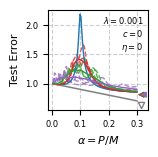

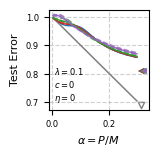

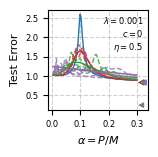

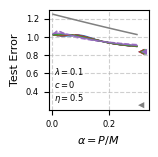

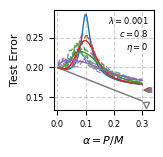

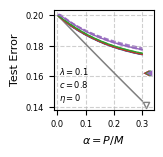

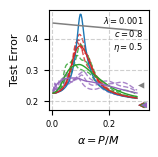

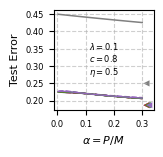

In [67]:
plot_data = np.load('plot_data.npy', allow_pickle=True).item()
reg_color = 'gray'

ctr = 0

# Nested loops to iterate over (c, eta), lam, and std_frac
for c, eta_data in plot_data.items():
    for eta, lam_data in eta_data.items():
        for lam, data in lam_data.items():
            
            # Initialize a new plot for each (c, eta, lam) combination
            fig, ax = plt.subplots()

            #Plot the optimally homogeneous and optimally regularized curves
            ax.plot(data['alphas_theory'][:-1], data['homErrorCurve'][:-1], label = 'Homogeneous', color = colors_base[0], lw = 1, zorder = 2)
            x_marker = ax.get_xlim()[1]
            plt.scatter(x_marker, data['homErrorCurve'][-1], marker='<', c=colors_base[0], s=20, edgecolors='none')
            ax.plot(data['alphas_theory'][:-1], data['ORFCCurve'][:-1], label = r'Fully Connected $\lambda = \lambda^*$', color = reg_color, lw = 1.1, zorder = 2)
            if data['ORFCCurve'][-1]>0:
                plt.scatter(x_marker, data['ORFCCurve'][-1], marker='<', c=reg_color, s=20, edgecolors='none')
            else:
                plt.scatter(x_marker, ax.get_ylim()[0], marker='v', c='white', s=20, edgecolors=reg_color)
            meanHetErrorCurves =  np.mean(data['hetErrorCurves'], axis=2)
            
            # Loop over std_frac values to plot multiple curves on the same plot
            colorind = 1
            for std_frac_ind, std_frac in enumerate(std_fracs):
                ax.plot(data['alphas_theory'][:-1], meanHetErrorCurves[:-1, std_frac_ind], label = rf'$\sigma k = {std_frac}$', color = colors_base[colorind], lw = 1)
                plt.scatter(x_marker+.005*(colorind-1), meanHetErrorCurves[-1, std_frac_ind], marker='<', c=colors_base[colorind], s=20, edgecolors='none')
                for i in range(3):
                    ax.plot(data['alphas_theory'][:-1], data['hetErrorCurves'][:-1, std_frac_ind,i], lw = 1, color = colors_base[colorind], ls = '--', alpha = .8, zorder = 1)
                colorind+=1
                
            # Add labels, title, and legend
            ax.set_xlabel(r'$\alpha = P/M$')
            ax.set_ylabel('Test Error')
            #ax.set_title(rf'$\lambda = {lam}$, $c = {c}$, $\eta = {eta}$')

            set_size(1,1)
            # Getting the limits of x and y axes
            x_min, x_max = ax.get_xlim()
            y_min, y_max = ax.get_ylim()

            # Calculate offsets based on a percentage of the axis range (e.g., 5%)
            x_offset = 0.05 * (x_max - x_min)
            y_offset = 0.05 * (y_max - y_min)

            # Define the locations based on the axis limits and offsets
            locations = {
                "top_right": (x_max - x_offset, y_max - y_offset),
                "bottom_left": (x_min + x_offset, y_min + y_offset),
                "center": ((x_max + x_min) / 2, (y_max + y_min) / 2)
            }

            if location_names[locInds[ctr]]== 'top_right':
                # Choose one of the locations (e.g., "top_right")
                best_x, best_y = locations["top_right"]
                ax.text(best_x, best_y, fr'$\lambda = {lam}$' + "\n" + fr'$c={c}$'+"\n"+fr'$\eta={eta}$', verticalalignment='top', horizontalalignment='right', fontsize = SMALL_SIZE)
            
            if location_names[locInds[ctr]]== 'bottom_left':
                best_x, best_y = locations["bottom_left"]
                ax.text(best_x, best_y, fr'$\lambda = {lam}$' + "\n" + fr'$c={c}$'+"\n"+fr'$\eta={eta}$', verticalalignment='bottom', horizontalalignment='left', fontsize = SMALL_SIZE)
            
            if location_names[locInds[ctr]]== 'center':
                best_x, best_y = locations["center"]
                ax.text(best_x, best_y, fr'$\lambda = {lam}$' + "\n" + fr'$c={c}$'+"\n"+fr'$\eta={eta}$', verticalalignment='center', horizontalalignment='center', fontsize = SMALL_SIZE)
    
            ctr+=1    
            ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid
            fig.savefig(f'HomVsHet_lam_{lam}_c_{c}_eta_{eta}.svg', dpi=300, bbox_inches='tight', transparent = True)

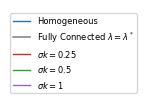

In [71]:
# Create an empty plot
fig_legend, ax_legend = plt.subplots()

# Create lines for the legend with the same properties as the ones in your plots
# Use empty lists as the x and y data points to create "invisible" lines
line_homogeneous, = ax_legend.plot([], [], label='Homogeneous', color=colors_base[0], lw=1)
line_fully_connected, = ax_legend.plot([], [], label=r'Fully Connected $\lambda = \lambda^*$', color=reg_color, lw=1.1)

# Create lines for std_frac values
lines_std_frac = []
for colorind, std_frac in enumerate(std_fracs, start=1):
    line, = ax_legend.plot([], [], label=rf'$\sigma k = {std_frac}$', color=colors_base[colorind], lw=1)
    lines_std_frac.append(line)

# Add them to the legend
handles = [line_homogeneous, line_fully_connected] + lines_std_frac
labels = [h.get_label() for h in handles]

# Create the legend
ax_legend.legend(handles=handles, labels=labels)

# Hide axes
ax_legend.axis('off')

# Save the legend as an SVG file
fig_legend.savefig('legend_only.svg', dpi=300, bbox_inches='tight', transparent=True)


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gamma
import matplotlib.cm as cm

def plot_gamma_pdf(mean, std_devs, spacing=1):
    deltastd = std_devs[1]-std_devs[0]
    numCurves = std_devs.shape[0]
    print(numCurves)
    x = np.linspace(0, 5 * mean, 1000)

    fig, ax = plt.subplots()
    
    cmap = cm.get_cmap('plasma')
    colors = cmap(np.linspace(0, 1, numCurves))
    
    bounds = np.linspace(0, std_devs[-1]+deltastd, numCurves+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    for i in range(0, numCurves, spacing):
        std_dev = std_devs[i]
        shape = (mean / std_dev) ** 2
        scale = std_dev ** 2 / mean
        y = gamma.pdf(x, shape, scale=scale)

        color = colors[i]
        ax.plot(x, y, label=round(std_dev, 3), color=color)

    ax.set_xlabel(r'$\nu$')
    ax.set_ylabel('Probability Density')
    ax.set_yscale('log')
    ax.set_xlim([0, .3])
    ax.set_ylim([0.09, 25])
    
    # Create a discrete colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, boundaries=bounds, ticks=bounds[:-1]+deltastd/2)

    cbar_labels = [round(sd, 3) for sd in np.linspace(std_devs[0], std_devs[-1], len(cbar.get_ticks()))]
    cbar.ax.set_yticklabels(cbar_labels)  # vertically oriented colorbar
    cbar.set_label(r'Standard Dev. $\sigma$')
    ax.set_xticks([0,.1,.2,.3])
    ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid
    set_size(2,4/3)
    plt.savefig('GammaDistMean.1.svg', bbox_inches='tight', dpi = 300, transparent = True)
    plt.show()

10


/tmp/ipykernel_1632239/552965698.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

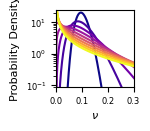

In [70]:
plot_gamma_pdf(1/10, np.round(np.linspace(.2/10, 2/10, 10), 2), spacing = 1)